<a href="https://colab.research.google.com/github/elazar1075/hotel_manage/blob/main/Hotel_Management_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hotel Management System
This system purpuse is to manage Reservations , Room availability , Check in and Check out operations,the system responsible to prevent overlaping between reservations and Room occupation , The system will free Rooms due to Reservation cancelation.



The program usese in Python API , re ,datetime,csv,json and fpdf

In [ ]:
!pip install fpdf
!pip install schedule

In [ ]:
import os
import csv
import json
import re
import schedule
import time
from datetime import datetime, timedelta
import pytz
from fpdf import FPDF


List for Menu's and card Input users and RegEx checking Lists

In [ ]:
main_menu = ['Apply Reservation', 'Cancel Reservation', 'Show Room Prices', \
            'Check In','check out','Show/print Reservation','Guests in Hotel','Future Reservation with Guest details','Search available Room','Reset System','EXIT']
show_res_menu=['Search Done Reservations ','Search Canceled Reservations','Search Future Reservations','Search Actual Reservations','EXIT']
make_resv_params = ['First Name : ', 'Last Name : ', 'Guest  ID : ', 'Check in[dd/mm/yyyy] : ', 'Duration : ', \
                    'Room Type [0]single [1]king size [2]double [3]twin [4]triple [5]quad [6]suite : ', \
                    'Cell Phone : ','e-mail : ','Payment Method  [1]-Cash [2]-Credit Card [3]-Cheqes']
make_resv_regex=['([A-Za-z]*)\s?-?([A-Za-z]*)?','([A-Za-z]*)\s?-?([A-Za-z]*)?','\d{9,}',\
 '\d{1,2}/\d{1,2}/20\d{2}','\d{1,2}','[0-6]','\d+','([\w\.-]+)@([\w\.-]+)','[1-3]']
search_room_params=['Date to Check in : ','Duration : ']
search_room_regex=['\d{1,2}/\d{1,2}/20\d{2}','\d{1,3}']
#'[a-z]+\s?[a-z]+?'
cancel_resurvation_card=['By Enter Reservation ','Search reservation to Cancel','Quit']
room_type_list=['single','king size','double','twin','triple','quad','suite']

In [ ]:
def reservatin_show(a,b,c,d,e,f,g,h,i,j):
  print(f"""
        Name :{a} {b} , ID: {c}
        Check in: {d} ,Duration: {e} 
        Room Number :{f}, Room Type: {g}
        phone:{h}  ,  email: {i}
        Payment Method:{j}
  """)

In [ ]:
reservatin_show('elaza','dahan','037693355','20/02/2022',3,'single','101','0524622788','elazar1075@gmail.com','cash')


        Name :elaza dahan , ID: 037693355
        Check in: 20/02/2022 ,Duration: 3 
        Room Number :single, Room Type: 101
        phone:0524622788  ,  email: elazar1075@gmail.com
        Payment Method:cash
  


####Room Date Table
The Room Date Table is a csv file that represent rooms vs. Dates 
The first row present dates and the first column present Room numbers, the table cells can hold some values ,see explaination below

'AV' mean available it mean that in this room and in that day the room is free and can be occupied by Reservation.

'CKIN' mean Check In ,the room is checked in  this day ,and can only use for check out .

'CKOUT' mean Check out ,you can use this date and that room only for Check in.

'OC' mean occupied , this room is occupied allready you can't use  this room in that date.

'OL' mean overlapping this mean that in this room and that day the room is Checked out and checked in in the same day 'OL'='CKOUT'+ 'CKIN'
the room is occupied you can't use it  for another reservation.

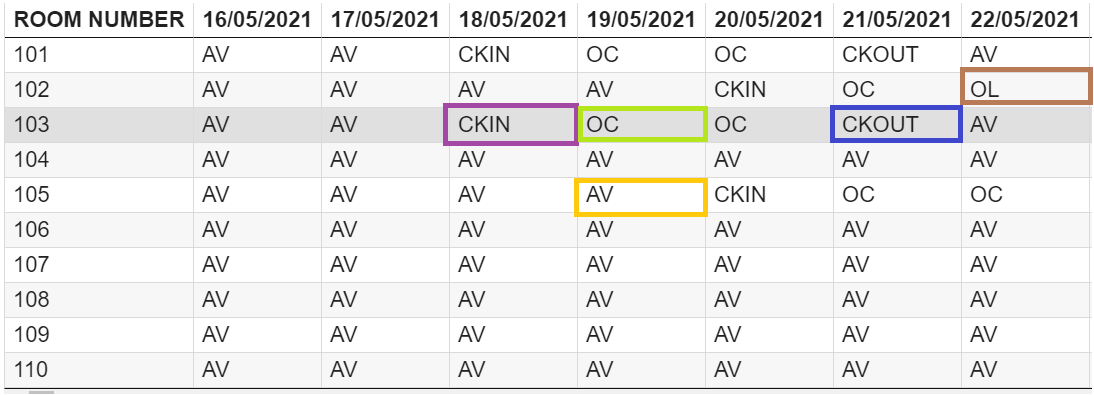

The function 'find_available_rooms' search in RoomDate csv file for available rooms the function get params Check in , Duration time and a list of Room numbers and resturn list of room that available for this dates.

In [ ]:
def find_available_rooms(chkin_date, duration, ls_rooms):
    room_date_csv = 'RoomDate.csv'
    with open(room_date_csv, 'r') as f_rooms:
        f = csv.reader(f_rooms)
        starti = 0
        endi = 0
        for c, i in enumerate(f):
            if c == 0:
                starti = i.index(chkin_date)
                d = datetime.strptime(chkin_date, '%d/%m/%Y')
                d = d + timedelta(days=duration)
                endi = i.index(d.strftime('%d/%m/%Y'))
                continue
            if i[0] not in ls_rooms:
                continue
            for k in range(starti, endi + 1):
                if k == starti + 1 and  i[k] == 'CKOUT' :
                    break
                if k == endi + 1 and i[k] == 'CKIN' :
                    break
                if i[k] == 'AV' :
                    break
                if i[0] in ls_rooms:
                    ls_rooms.remove(i[0])
        return ls_rooms


In [ ]:
print(find_available_rooms('26/05/2021',4,['101','102','103']))

['101', '103']


The function 'free_or_occupied_room' occupied room or free room depend if this is a new Reservation or Reservation cancelation , the function params is check in date and duration ,number of room and key 'occupied' or 'free' the function access to RoomDate csv file

In [ ]:
def free_or_occupied_room(chkin_date, duration, str_room_number,key='occupied'):
    f_o=-1
    if key=='free' :
        f_o=0
    else:
        f_o=-1


    room_date_csv = 'RoomDate.csv'
    lst_csv = list()
    lst_csv2 = list()
    starti = 0
    endi = 0


    with open(room_date_csv, 'r') as radb:
        f = csv.reader(radb)

        for c, i in enumerate(f):
            lst_csv.append(i)
            lst_csv2.append(i)
            if c == 0:
                starti = i.index(chkin_date)
                d = datetime.strptime(chkin_date, '%d/%m/%Y')
                d = d + timedelta(days=duration)
                endi = i.index(d.strftime('%d/%m/%Y'))
    for c, item in enumerate(lst_csv):
        if str_room_number in item:
            for j in range(starti, endi + 1):
                if j == starti:
                    if item[j] == ['CKIN','CKOUT'][f_o]:
                        lst_csv2[c][j] = ['AV','OL'][f_o]
                        continue
                    elif item[j] == ['OL','AV'][f_o]:
                        lst_csv2[c][j] = ['CKOUT','CKIN'][f_o]
                        continue
                    else:
                        return False
                elif j == endi:
                    if item[j] == ['OL','CKIN'][f_o]:
                        lst_csv2[c][j] =['CKIN','OL'][f_o]
                        continue
                    elif item[j] == ['CKOUT','AV'][f_o]:
                        lst_csv2[c][j] = ['AV','CKOUT'][f_o]
                        continue
                    else:
                        return False
                elif lst_csv2[c][j] == ['OC','AV'][f_o]:
                  lst_csv2[c][j] =['AV','OC'][f_o]
                elif item[j] !=['OC','OL'][f_o]:
                    return False
    with open(room_date_csv, 'w', newline='') as f_rooms_write:
        writer = csv.writer(f_rooms_write)
        writer.writerows(lst_csv2)
    return True

In [ ]:
free_or_occupied_room('03/06/2021',5,'306',key='free')


False

The funcion 'list_rooms_by_type' return list of room numbers due to its parameter room_type that can be the Room Type for Ex. 'single' , 'king size', 'suite' etc. if room_type='all' it's return all the Rooms in the Hotel.

In [ ]:
def list_rooms_by_type(room_type):
      room_list=list()
      with open('rooms.json','r')as f_room_attr:
          room_dict=json.load(f_room_attr)
      for room in room_dict['rooms']:
        if room_type=='all':
          room_list.append(room['number'])
        elif room['room type']==room_type :
              room_list.append(room['number'])
      return  room_list


In [ ]:
 ls=list_rooms_by_type('suite')
 for i in ls:
   print (f'Room number {i}')

Room number 303
Room number 304
Room number 305
Room number 306


##Json Files
Few words about json files
There is a several json files in the system.
'guests.json' holds the guests details cards when the guest checked in \checked out or cancel the reservation the guest card updated accordinley.
'reservation4.json' hold the future reservation detailed card.
'canceled_reservs.json' holds the canceled reservations, when reservation canceled the relevant reservation card moves from 'reservation4.json' to 'canceled_reservs.json'.
'active_reservs.json' holds the reservation that checked in , when the guest is checked in the relevant reservation card moves from 'reservation4.json'  to  'active_reservs.json'.
'done_reservs.json' holds the reservation that ended, when the guest is checked out the relevant reservation moves from 'active_reservs.json' to 'done_reservs.json'.

'rooms.json' holds each room in seperate card and it's attributes (room type)
'prices.json' hold the room type prices /and bevrage prices(not used yet!)


Example json Files
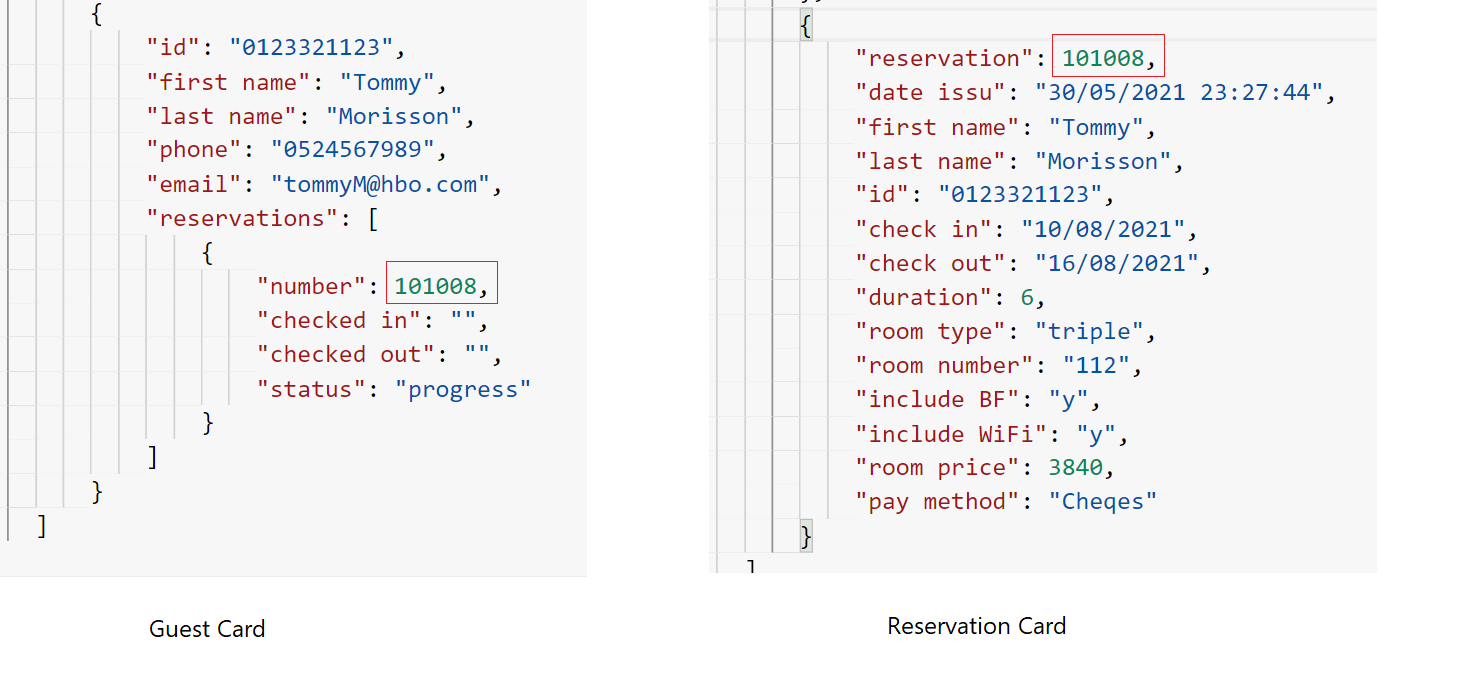

The function 'add_reservation' takes parameters and create a reservation card enterance in 'reservation4.json; file that hold the future resrvations , the function checks if the guest is registered in 'guests.json' file that hold the guest card if the guest is not regitered the reservation will not created.you need to register the guest with 'register_guest' function before using this function to make reservation.

In [ ]:
def add_reservation(first_name,last_name,guest_id,check_in,\
        duration,room_type,room_number,include_breakfest,include_WiFi,pmethod):

  is_exist=False
  with open('guests.json','r') as f_guest:
      guest_dict = json.load(f_guest)
  for item in guest_dict["guests"]:
      if item['id'] == guest_id:
          is_exist=True
          break
  if is_exist==False:
      return -1
  reservation_dict={}
  list_of_reservations=list()
  d = datetime.strptime(check_in,'%d/%m/%Y')
  d=d+timedelta(days=duration)
  check_out=d.strftime('%d/%m/%Y')
  with open("reservations4.json", 'r') as reserv_list:
      reservation_dict = json.load(reserv_list)
  for res in reservation_dict['reservations']:
      list_of_reservations.append(int(res['reservation']))
  max_num=reservation_dict['max_reservation'][0]["max"]
  reservation_dict['max_reservation'][0]["max"]=int(max_num) + 1
  # print(room_type)
  room_price=get_room_price(room_type) * duration
  date_issu = datetime.now().strftime('%d/%m/%Y %H:%M:%S')
  dict_res={'reservation':max_num,'date issu':date_issu,'first name':first_name,'last name':last_name,\
            'id':guest_id,'check in':check_in,'check out':check_out,'duration':duration,\
            'room type':room_type,'room number':room_number,'include BF':include_breakfest,
            'include WiFi':include_WiFi,'room price':room_price,"pay method":pmethod}
  reservation_dict['reservations'].append(dict_res)
  with open("reservations4.json", 'w') as reserv_list:
      json.dump(reservation_dict, reserv_list, indent=4)
  pass
  return max_num

The function 'delete_resrvation' take reservation from 'reservation4.json' file and put in 
'canceled_reservs.json' or 'done_reservs.json'   or 'active_reservs.json' depend if the reservation was canceled  or checked out or checked in 
(key = 'cancel' or 'done' or 'active' respectivly).

In [ ]:
def delete_reservation(int_reserv_to_del,key='done') :
    is_found=False
    to_del=int()
    reservation_dict=dict()
    cancel_reservation_dict =dict()

    if key== 'cancel':
      res_file="canceled_reservs.json"
      reservations='reservations4.json'
    elif key=='active':
      res_file='active_reservs.json'
      reservations='reservations4.json'
    elif key=='done':
      res_file="done_reservs.json"
      reservations='active_reservs.json'
    with open(reservations, 'r') as reserv_list:
        reservation_dict = json.load(reserv_list)
    with open(res_file, 'r') as cancel_reserv_list:
        cancel_reservation_dict = json.load(cancel_reserv_list)
    cancel_reservation_dict['max_reservation'][0]['max']=reservation_dict['max_reservation'][0]['max']
    for c,inner_dict in enumerate(reservation_dict["reservations"]):
        # reservation_dict["reservations"] is a list
        if inner_dict["reservation"]==int_reserv_to_del:
            to_del=c
            is_found=True
    if is_found:
        cancel_reservation_dict["reservations"].append(reservation_dict["reservations"].pop(to_del))
        with open(reservations, 'w') as reserv_list:
            json.dump(reservation_dict, reserv_list, indent=4)
        with open(res_file, 'w') as cancel_reserv_list:
            json.dump(cancel_reservation_dict, cancel_reserv_list, indent=4)
    return is_found


get_room_price return the price of the room due to  the parameter room_type , that can be 'single' , 'double', 'king size','suite'...etc.
the prices are in 'prices.json' file.

In [ ]:
def get_room_price(room_type):
    prices_dict=dict()
    with open ('prices.json','r') as f_prices:
       prices_dict = json.load(f_prices)
    for item in prices_dict['room price']:
      return item[room_type]

In [ ]:
get_room_price('king size')

550

The 'register_guest' register a guest,after succesfuly process , you can make reservation to this guest.

In [ ]:
def register_guest(first_name,last_name,gid,phone,eml):
  guests_dict=dict()
  with open('guests.json','r') as f_guests:
    guests_dict=json.load(f_guests)
  if len(guests_dict['guests'])!=0:
    for item in guests_dict['guests']:
        if item['id']==gid :
            print('Guest allredy register')
            return
  register_dict={'id': gid,'first name': first_name,'last name': last_name,'phone':phone,'email':eml,'reservations': []}

  guests_dict['guests'].append(register_dict)
  with open('guests.json', 'w') as f_guests_out:
    json.dump(guests_dict,f_guests_out,indent=4)


        

The Function 'update_guest_resrevation' update Reservations status in guest card that created in 'register_guest' function.The function get 3 parameters , guest id , reservation number, and key .The guest may have sevaral Reservation this function update the status to , 'active' when key = 'check in',
to 'done' when key ='check out' and 'cancel' when key='cancel',in case of key = 'check in' or 'check out' the function update the 'checked in' or 'checked out' resepectivly with the time and date when the action accured.

In [ ]:
def update_guest_resrevation(gid,reservation_num,key):
    guests_dict=dict()
    with open ('guests.json','r') as f_guests:
        guests_dict=json.load(f_guests)
    for guest in guests_dict['guests']:
      if guest['id']== gid:
        if key == 'new':
          guest['reservations'].append({'number': reservation_num, 'checked in': '', 'checked out':'','status':'progress'})       
        else:
            for i in guest['reservations']:
              if i['number']==reservation_num:
                if key=='check in' and i['status'] =='progress':
                  i['checked in']=datetime.now().strftime('%d/%m/%Y %H:%M:%S')
                  i['status']='active'
                elif key=='check out'and i['status']=='active':
                  i['checked out']=datetime.now().strftime('%d/%m/%Y %H:%M:%S')
                  i['status']='done'
                elif key=='cancel' and i['status']=='progress':
                  if i['status']== 'active' or i['status']=='done':
                    print(i['status'])
                    return False
                  else:
                    i['status']='cancel'
                else:
                  return False
    with open('guests.json','w') as f_guest_out:
        json.dump(guests_dict, f_guest_out, indent=4)
    return True

## Menu Handeling Functions

The function 'make_menu' create a numbered menu it takes the menu words from list that declare previously ,and take another str parameter for the menu title.
the function return user selection if it's valid if not it's return -1.

In [ ]:
def make_menu(mlist, menu_title):
    print(menu_title)
    print('-' * len(menu_title))
    for cnt, item in enumerate(mlist):
        print(f'[{cnt + 1}] {item}')
    user_select=input("SELECT : ")
    if user_select.isdigit():
        user_select=int(user_select)
    else:
        return
    if user_select in range(0,len(mlist)+1):
        return user_select
    return -1

The function 'make_card_params' take input data from user,the difference between this function and make_menu function is that this function take typed parameters like first name , last name ,ID , Date and the make_menu is only number selection.

In [ ]:
def make_card_params(list_params, card_title) :
    print(card_title)
    lst_params = []
    for select in list_params:

        user_input = input(select)
        lst_params.append(user_input)
    return lst_params

The function 'validate_input' checks if the user/guest inputs are valid.it uses the re package for this task.

In [ ]:
def validate_input(str_input,inp_pattern):
    match = re.match(inp_pattern,str_input)
    if match is not None :
        if len(match.group())==len(str_input):
            return True
        else:
            return False
    return  False
def check_date_validity(str_date):
    input_date=datetime.now()
    try:
        input_date=datetime.strptime(str_date,'%d/%m/%Y')
    except ValueError:
        #print("The Date  is Not Exist")
        return False
    # today_date=datetime.now()
    date_utc=(datetime.now(tz=pytz.UTC))

    today_isr = date_utc.astimezone(pytz.timezone('Asia/Jerusalem'))
    today=(today_isr.strftime('%d/%m/%Y'))
    if today_isr.date() > input_date.date() :
        #the date must be higher or equal to now()
        return False

    return True

# Search Reservations & Guests  Data Functions

In [ ]:
def get_rservation_attrib(reserv_num,res_attrib="id",key='progress'):
    reserv_dict = dict()
    if key=='cancel':
      reservations='canceled_reservs.json'
    elif key=='done':
      reservations='done_reservs.json'
    elif key=='active':
      reservations='active_reservs.json'
    elif key== 'progress':
      reservations='reservations4.json'
    with open(reservations, 'r') as f_reserv:
        reserv_dict = json.load(f_reserv)
    for item in reserv_dict['reservations']:
        if item['reservation'] == reserv_num:
          return item[res_attrib]

In [ ]:
def search_reservation_by_key(key_enter,value,key='progress'):
    reservation_dict = dict()
    reservation_list= list()
    res_file=''
    if key=='progress':
      res_file='reservations4.json'
    elif key=='done':
      res_file='done_reservs.json'
    elif key=='canceled':
      res_file='canceled_reservs.json'
    elif key=='active':
      res_file='active_reservs.json'


    with open(res_file, 'r') as reserv_list:
        reservation_dict = json.load(reserv_list)
    for inner_dict in reservation_dict["reservations"]:
        if inner_dict[key_enter]== value :
            reservation_list.append(inner_dict)
    return reservation_list

The function 'guest_by_reserv_status' get status parameter and return guests information 
(List of Lists) that have this status parameter in one of their Reservations (guest can have more than one reservation) the ststus can be ,'progress' fore future reservation, 'done' for finished reservation (due to check out), 'cancel' for canceled reservation and 'active' for |Reservation that are now active (the Guest/s in the Hotel)

In [ ]:
def guest_by_reserv_status(status='active'):
  dict_guests=dict=()
  ls_guest=list()
  with open('guests.json','r') as f_guests:
    dict_guests=json.load(f_guests)
  for item in dict_guests['guests']:
    for i in item['reservations']:
      if i['status']== status:
        ls_guest.append([item['id'],item['first name'],item['last name'],item['phone'],item['email'],i['number']])
  return ls_guest

The search_reservation_by_name function
Search Reservation by name , it mean by reservation number,the key tell to the function in wich json file to search the reservation.you don't have to enter the full reservation number ,for ex. for 1*2 the result will be a list of reservation numbers like 10293339 ,10293340, 
10293341.... etc. the search can be in 'reservations4.json' that keeps the future reservations when key='progress'(default),in 'canceled_reservs.json' that keep the canceled reservations when the key = 'cancel' and 'done_reservs.json' that keep reservations that finished due Check Out operation when key='done'
and 'active_reservs.json' that keeps the checked in reservations when key='active'.

In [ ]:
def search_reservation_by_name(st_input,key='progress'):
  res_file=''
  if key=='progress':
    res_file='reservations4.json'
  elif key=='canceled':
    res_file='canceled_reservs.json'
  elif key=='done':
    res_file='done_reservs.json'
  elif key=='active':
    res_file='active_reservs.json'
  
  reserv_found_list=list()
  resev_dict=dict()
  ls_input=list()
  st_is_digit=str()
  with open(res_file,'r')  as f_reserv:
      reserv_dict= json.load(f_reserv)
  reserv_len=len(str(reserv_dict['max_reservation'][0]['max']))
  mul=reserv_len - len(st_input)
  st_is_digit=st_input.replace('*','1')
  if st_is_digit.isdigit():
      st_input=st_input.replace('*','[0-9]?')
      ls_input=list(st_input)
      ls_input=ls_input +['[0-9]?'* mul]
      st_input=''.join(ls_input)
      with open(res_file,'r')  as f_reserv:
          resev_dict=json.load(f_reserv)
      for i in resev_dict['reservations']:
          try:
            
              m=re.match(st_input,str(i['reservation']))
              reserv_found_list.append(m.group())
          except:
              continue

  return reserv_found_list

In [ ]:
def passed_dates_for_check_in_or_out(date_to_compare,key='check in'):
  if key=='check in':
    reservs_file='reservations4.json'
  elif key=='check out':
    reservs_file='active_reservs.json'
  reservation_list=list()
  reserv_dict=dict()
  with open(reservs_file) as f_reserv:
    reserv_dict=json.load(f_reserv)
  for item in reserv_dict['reservations']:
    
    if datetime.strptime(item[key],'%d/%m/%Y') < datetime.strptime(date_to_compare,'%d/%m/%Y'):
      reservation_list.append(item)

  return (reservation_list)

In [ ]:
passed_dates_for_check_in_or_out('14/06/2021',key='check out')

[{'check in': '02/06/2021',
  'check out': '05/06/2021',
  'date issu': '30/05/2021 20:52:00',
  'duration': 3,
  'first name': 'jon',
  'id': '0088998899',
  'include BF': 'y',
  'include WiFi': 'y',
  'last name': 'do',
  'pay method': 'Credit Card',
  'reservation': 101001,
  'room number': '101',
  'room price': 1350,
  'room type': 'single'},
 {'check in': '03/06/2021',
  'check out': '08/06/2021',
  'date issu': '30/05/2021 21:37:46',
  'duration': 5,
  'first name': 'don',
  'id': '087687687',
  'include BF': 'y',
  'include WiFi': 'y',
  'last name': 'king',
  'pay method': 'Cheqes',
  'reservation': 101003,
  'room number': '306',
  'room price': 6000,
  'room type': 'suite'},
 {'check in': '03/06/2021',
  'check out': '08/06/2021',
  'date issu': '30/05/2021 22:13:18',
  'duration': 5,
  'first name': 'kal',
  'id': '0111111111',
  'include BF': 'y',
  'include WiFi': 'y',
  'last name': 'el',
  'pay method': 'Cash',
  'reservation': 101006,
  'room number': '303',
  'room pr

# Handel Print

functin 'print_pdf' and class PDF create a pdf vertion of Reservation.

In [ ]:
from fpdf import FPDF

class PDF(FPDF):
  def header(self):
   
   self.image('/content/hotel_bel.jpg',10,20,50)
   
def print_pdf(dict_res):
  st_hotel=str()
  ls_hotel=list()
  with open ('hotel.txt','r') as f:
    ls_hotel=f.readlines()
  st_hotel=''.join(ls_hotel)
  ls_fname=list()
  
  pdf=PDF('P', 'mm', 'A4')

  pdf.add_page()
  pdf.set_font('Arial', '', 16)
  pdf.set_title('Hotel Recipient')
  pdf.cell(30,55,ln=1)
  for key in dict_res:
    pdf.cell(110,10,(f'{key.title():<15}  {dict_res[key]}'),border=True,ln=True)
  pdf.cell(10,10,ln=1)
  pdf.set_font('times','B',20)
  pdf.multi_cell(190,10,st_hotel)
  ls_fname.append('Res')
  ls_fname.append(str(dict_res['reservation']))
  ls_fname.append('.pdf')
  st_fname=''.join(ls_fname)
  pdf.output(st_fname)


 example of add reservation 


---


  Add Reservation Menu

---



  First Name : wil


---


  Last Name : smith


---


  Guest  ID : 089898944


---


  Check in[dd/mm/yyyy] : 20/06/2021

---

  Duration : 2

---

  Room Type [0]single [1]king size [2]

  double [3]twin [4]triple [5]quad [6]suite : 3

---

  Cell Phone : 0524355677

---

  e-mail : wills@prince.com

---

  Payment Method  [1]-Cash [2]-Credit Card [3]-Cheqes3

---

  Select A Room Number from the list 

  205

  206

  301

  302
  

  Select A Room Number  205

---

        Name :wil smith , ID: 089898944
        Check in: 20/06/2021 ,Duration: 2 
        Room Number :205, Room Type: twin
        phone:0524355677  ,  email: wills@prince.com
        Payment Method:Cheqes
  
Approve Resetrvation [1]Yes  [Any]Cancel 1

#Main Function
  ## Main Loop 

In [ ]:



reset_system_date=str()
date_utc=datetime.now(tz=pytz.UTC)
today_isr = date_utc.astimezone(pytz.timezone('Asia/Jerusalem'))

today=(today_isr.strftime('%d/%m/%Y'))
logtxt='log'+today_isr.strftime('%m%Y')+'.log'


# -------------Forced Check in in case of guest not checked in from a  reason-------------------
def forced_checkin():
  reservs_to_forced_checkin=passed_dates_for_check_in_or_out(today,key='check in')
  for item in reservs_to_forced_checkin:
    gid=item['id']
    fname=item['first name']
    lname=item['last name']
    res_to_checked_in=item['reservation']
    delete_reservation(res_to_checked_in,key='active')
    update_guest_resrevation(gid,res_to_checked_in,key='check in')
    # print(f'Reservation number {res_to_checked_in} of Guest {fname} {lname}  ID: {gid} Forced check in ')
    with open (logtxt,'a') as flog:
      flog.write(f'Reservation number {res_to_checked_in} of Guest {fname} {lname}  ID: {gid} Forced check in \n')

# -------------Forced Check out in case of guest not checked out from a  reason-------------------
def forced_checkout():
  reservs_to_forced_checkout=passed_dates_for_check_in_or_out(today,key='check out')
  for item in reservs_to_forced_checkout:
    gid=item['id']
    fname=item['first name']
    lname=item['last name']
    res_to_checked_out=item['reservation']
    delete_reservation(res_to_checked_out,key='done')
    update_guest_resrevation(gid,res_to_checked_out,key='check out')
    # print(f'Reservation number {res_to_checked_out} of Guest {fname} {lname}  ID: {gid} Forced check out ')
    with open (logtxt,'a') as flog:
      flog.write(f'Reservation number {res_to_checked_out} of Guest {fname} {lname}  ID: {gid} Forced check out \n')


#-----------------------------------Main Menu----------------------------------------
add,cancel,show,chk_in,chkout,res_print,guests,future_res,search_room,rsystem,exit_val=1,2,3,4,5,6,7,8,9,10,11
select=-2
room_number=''
is_validate=False
true_or_false=list()
while(select != exit_val):
  print(datetime.now())
  select=make_menu(main_menu,'Main Menu')
  print(select)
  
#--------------------------ADD  RESERVATION---------------------------------------------
  if select == add :
    isfree=bool()
    print('add reservation')
    input_params=(make_card_params(make_resv_params,'Add Reservation Menu'))
    fname,lname,gid,chkin,duration,rtype,phone,eml,pmd = tuple(input_params)
    
    
    for c,item in enumerate(input_params):
      true_or_false.append(validate_input(item,make_resv_regex[c]))#return list of True and False
    # print(true_or_false)
    if False not in true_or_false:
      room_type=room_type_list[int(rtype)]
      dur=int(duration)
      pmethod=['Cash','Credit Card','Cheqes'][int(pmd)-1]
      if check_date_validity(chkin): # check date validity after first filtered by "validate input"
        chkin=datetime.strptime(chkin,'%d/%m/%Y').strftime('%d/%m/%Y')#change date format ex. 7/3/2021 to 07/03/2021 for access RoomDate table
        print('Input params are validate')
        is_validate=True
      else:
        is_validate=False
        print('invalid Date format')
    true_or_false=[]
    if is_validate:
      ls=list_rooms_by_type(room_type)
      available_rooms=find_available_rooms(chkin,dur,ls)
      print("Select A Room Number from the list ")
      for room in available_rooms:
        print(f'{room}')
      room_number=input("Select A Room Number")
      while room_number not in available_rooms:
          room_number=input("Room not in list, Select again :")
      reservatin_show(fname,lname,gid,chkin,duration,room_number,room_type,phone,eml,pmethod)
      ans=input('Approve Resetrvation [1]Yes  [Any]Cancel')
      if ans=='1':  
        isfree=free_or_occupied_room(chkin, dur, room_number,key='occupied')
        print(isfree)
        if isfree:
          register_guest(fname,lname,gid,phone,eml)
          reservation_num=add_reservation(fname,lname,gid,chkin,dur,room_type,room_number,'y','y',pmethod)
          print(reservation_num)
          if reservation_num!=-1:
            update_guest_resrevation(gid,reservation_num,key='new')
        else:
          print('Room Not avilable')
      else:
        print('cancel process')

#---------------------CANCEL  RESERVATION---------------------------------------------
  elif select==cancel:
    
    sel=make_menu(cancel_resurvation_card,'Cancel Reservation')
    if sel==1:
      res= make_card_params(['enter Reservation number'],'Cancel a reservation')
    elif sel==2:
      reservation_to_cancel=int()
      # print('''Enter Reservation to search you can enter a full reservation
      # number  or partial number with *') '''
      print("""NOTE: you can enter reservation number or number with "*" mixed\n 
      for ex. value of 1*1 can  give a list of numbers 1011234, 1012345, 121838,for example.""")
      inp_res = input('Enter Value to search:  ')
      res_list = search_reservation_by_name(inp_res,key='progress')
      for c,item in enumerate(res_list):
        print(f'[{c+1}] {item}')
      sel_num=int(input('Select Number from the List to Delete , [0] to cancel '))
      if sel_num!=0:
        reservation_to_cancel=int(res_list[sel_num - 1])
        dt=get_rservation_attrib(reservation_to_cancel,res_attrib='check in')
        dur=get_rservation_attrib(reservation_to_cancel,res_attrib='duration')
        room=get_rservation_attrib(reservation_to_cancel,res_attrib='room number')
        gid=get_rservation_attrib(reservation_to_cancel,res_attrib='id')
        if check_date_validity(dt):
          free_or_occupied_room(dt,dur,room,key='free')
          delete_reservation(reservation_to_cancel,key='cancel')
          update_guest_resrevation(gid,reservation_to_cancel,key='cancel')
        else:
          print(f'the cabnelation date of reservation number {res_list[sel_num - 1]} past')

        
      else:
        input('operation canceld , press any key')



  elif select==show:
    print('Room Prices')
    print(' Room Type        Price')
    print('-------------------------------')
    for room in room_type_list:
      print(f""" {room:<10}        {get_room_price(room)}
    -------------------------------
    """)
      
#---------------------------------CHECK IN----------------------------------------------
  elif select==chk_in:
    list_of_res_nums=list()
    list_of_id_nums=list()
    print('Check in')

    print(today)
    
    today_to_checked_in = search_reservation_by_key('check in',today,key='progress')
    if len(today_to_checked_in) == 0:
      print('There is no Reservations to check in today')
    else:

      print('[{}] {:<12} {:<12} {:<12} {}'.format('x','Reservation','First Name','Last Name','ID'))
      for c,item in enumerate(today_to_checked_in):
       list_of_res_nums.append(item['reservation'])
       list_of_id_nums.append(item['id'])

       print('[{}] {:<12} {:<12} {:<12} {}'.format(c,item['reservation'],item['first name'],item['last name'],item['id']))
      res=input('select reservation to check in')
      if res.isdigit():
        if int(res) in range(0,len(list_of_res_nums)):
          res_to_checked_in = list_of_res_nums[int(res)]
          gid=list_of_id_nums[int(res)]
          delete_reservation(res_to_checked_in,key='active')
          update_guest_resrevation(gid,res_to_checked_in,key='check in')

      else:
        print('Wrong input')
    input('Press Any Key...........')    
#---------------------------------CHECK OUT----------------------------------------------
  elif select==chkout:
    isupdate=bool()
    print('Check out')
    list_of_res_nums=list()
    list_of_id_nums=list()

    today_to_checked_out = search_reservation_by_key('check out',today,key='active')
    if len(today_to_checked_out) == 0:
      print('There is no Reservations to check out today')
    else:
      print('[{}] {:<12} {:<12} {:<12} {}'.format('x','Reservation','First Name','Last Name','ID'))
      for c,item in enumerate(today_to_checked_out):
       list_of_res_nums.append(item['reservation'])
       list_of_id_nums.append(item['id'])
       print('[{}] {:<12} {:<12} {:<12}  {}'.format(c,item['reservation'],item['first name'],item['last name'],item['id']))
      res=input('select reservation to check out')
      if res.isdigit() :
        if int(res) in  range(0,len(list_of_res_nums)):
          res_to_checked_out = list_of_res_nums[int(res)]
          gid=list_of_id_nums[int(res)]
          isupdate=update_guest_resrevation(gid,res_to_checked_out,key='check out')
          
          if isupdate:
            delete_reservation(res_to_checked_out,key='done')
          else:
            print('The Reservation Not Checked in ,So you can not Check out')
            ans=input ('do you wnat to forced check out ? [1]Yes [2] No')
            if ans=='1':
              
              forced_checkin()
              update_guest_resrevation(gid,res_to_checked_out,key='check out')
              delete_reservation(res_to_checked_out,key='done')

            elif ans=='2':
              print('reservation no checked out')

    input('Press Any Key...........')

            
# -------------------------------actual/done/cancel reservations----------------------------------
  elif select==res_print:
    sel=make_menu(show_res_menu,'Show Reservations')
    if sel==1:
      key_search='done'
    elif sel==2:
      key_search='canceled' 
    elif sel==3:
      key_search='progress'
    elif sel==4:
      key_search='active'
    else:
      key_search=0
    if key_search !=0:
      print("""NOTE: you can enter reservation number or number with "*" mixed
      for ex. value of 1*1 can  give a list of numbers 1011234, 1012345, 121838,for example.""")
      inp_res = input('Enter Value to search:  ')
      res_list = search_reservation_by_name(inp_res,key=key_search)
      if len(res_list)!=0:
        for c,item in enumerate(res_list):
          print(f'[{c+1}] {item}')
        sel_num=int(input('Select Number from the List to Show , [0] cancel '))
        if sel_num!=0 and sel_num <= len(res_list):
          print(type(res_list[sel_num-1]))
          dict_res=(search_reservation_by_key('reservation',int(res_list[sel_num-1]),key_search))[0]
          for key in dict_res:
            print(f'{key.title():<15}  {dict_res[key]}')
            # print_pdf(f'{key.title():<15}  {dict_res[key]}')
            print('-'*50)
          ans=input('make a pdf version press [1]YES [any key]NO')
          if ans=='1':
            print_pdf(dict_res)
            print('PDF file was produced')
      else:
        print(f'{key_search} reservation not found ')
    else:
      input('Exit Operation , Press any key to main menu')
# -------------------------------------Guests in Hotel-------------------------------------------------
  elif select==guests:
    # --------you need to reset system\forced check in\out that overdate to know the real number of guests in hotel---------------
    #---------if the system not reset today the system will reset here (the system reset only every day once by manualy or when the program loaded)
    print('Guests in Hotel')
    date_utc=datetime.now(tz=pytz.UTC)
    today_isr = date_utc.astimezone(pytz.timezone('Asia/Jerusalem'))
    reset_system_date=(today_isr.strftime('%d/%m/%Y'))
    if reset_system_date!=today:
      forced_checkin()
      forced_checkout()
      today=reset_system_date
    
    ls_guests=guest_by_reserv_status('active')
    for c,item in enumerate(ls_guests):
      print(f'[{c}]',end='')
      for i in item:
        print (i,end=' , ')
      print()
# -------------------------------------Guests with future Reservations---------------------------------
  elif select==future_res:
    # --------you need to reset system\forced check in\out that overdate to know the Guests with future Reservations---------------
    #---------if the system not reset today the system will reset here (the system reset only every day once by manualy or when the program loaded)
    date_utc=datetime.now(tz=pytz.UTC)
    today_isr = date_utc.astimezone(pytz.timezone('Asia/Jerusalem'))
    reset_system_date=(today_isr.strftime('%d/%m/%Y'))
    if reset_system_date!=today:
      forced_checkin()
      forced_checkout()
      today=reset_system_date

    print('Guests with future reservation/s')
    ls_guests=guest_by_reserv_status('progress')
    for c,item in enumerate(ls_guests):
      print(f'[{c}]',end='')
      for i in item:
        print (i,end=' , ')
      print()
    input('Press Any Key......')
#----------------------------------------------search room by dates---------------------------------------
  elif select==search_room:
    rtype=str()
    ls=list()
    true_or_false=list()
    sel=make_menu(room_type_list,'Select Room type to search')
    
    input_params=make_card_params(search_room_params,'Date slice')
    for c,i in enumerate(input_params):
      true_or_false.append(validate_input(i,search_room_regex[c]))
      if c== 0:
        true_or_false.append(check_date_validity(i))
    if False not in true_or_false:     
      date_inp=input_params[0]
      #nesecery for change date format for ex. 2/7/2021 to 02/07/2021 for access date in RoomDate table
      date_inp=datetime.strptime(date_inp,'%d/%m/%Y').strftime('%d/%m/%Y')
      if sel!=-1 or 0:
        r_type=room_type_list[sel-1]
      ls=list_rooms_by_type(r_type)
      ls_rooms=find_available_rooms(date_inp,int(input_params[1]),ls)
      print(f'Room Type [ {r_type} ] Available')
      for c,room in enumerate(ls_rooms):
        print(f'[{room}]  ',end='')
        if c==4:
          print()

      print()
      input('Press any key')
    else:
      input('One of your Inputs are wrong,press any key')
#--------------------------------Reset System/forced check in and out that overdate-----------------------
  elif select==rsystem:
    date_utc=datetime.now(tz=pytz.UTC)
    today_isr = date_utc.astimezone(pytz.timezone('Asia/Jerusalem'))
    reset_system_date=(today_isr.strftime('%d/%m/%Y'))
    if reset_system_date!=today:
      forced_checkin()
      forced_checkout()
      today=reset_system_date
  elif select==exit_val:
    print('EXIT')

  


2021-06-22 19:15:14.853508
Main Menu
---------
[1] Apply Reservation
[2] Cancel Reservation
[3] Show Room Prices
[4] Check In
[5] check out
[6] Show/print Reservation
[7] Guests in Hotel
[8] Future Reservation with Guest details
[9] Search available Room
[10] Reset System
[11] EXIT
SELECT : 1
1
add reservation
Add Reservation Menu
First Name : elaz
Last Name : cohen
Guest  ID : 034568877
Check in[dd/mm/yyyy] : 20/06/2021
Duration : 3
Room Type [0]single [1]king size [2]double [3]twin [4]triple [5]quad [6]suite : 2
Cell Phone : 0524985421
e-mail : ecohen@gmail.com
Payment Method  [1]-Cash [2]-Credit Card [3]-Cheqes2
invalid Date format
2021-06-22 19:17:20.326234
Main Menu
---------
[1] Apply Reservation
[2] Cancel Reservation
[3] Show Room Prices
[4] Check In
[5] check out
[6] Show/print Reservation
[7] Guests in Hotel
[8] Future Reservation with Guest details
[9] Search available Room
[10] Reset System
[11] EXIT
SELECT : 1
1
add reservation
Add Reservation Menu
First Name : elaza
Last 